# Montserrat event selector for Machine Learning
The aim of this code is to find the best N events of each type, and create a corresponding CSV file and data structure for entry into Alexis' and Marielle's AAA codes.

In [34]:
import os
from glob import glob
import pandas as pd
import numpy as np
from obspy.core import read
import sys
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libseisGT import mulplt

"""
#%matplotlib widget
%matplotlib inline

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

np.set_printoptions(linewidth=160)
"""

def read_volcano_def():
    filepath = './volcano_def.csv'
    subclass_df = pd.read_csv(filepath)
    subclass_df.columns = subclass_df.columns.str.lstrip()
    return subclass_df
    
def build_master_event_catalog(csvdir, seisandbname, catalogfile, subclasses, etypes):
    # load all the year/month CSV files
    csvfiles = glob(os.path.join(csvdir, 'reawav_%s??????.csv' % seisandbname))
    frames = []
    for csvfile in csvfiles:
        df = pd.read_csv(csvfile)
        frames.append(df) 
    dfall = pd.concat(frames, sort=True)
    dfall.set_index('filetime', inplace=True) # we will need this later to remerge

    # For simplicity, copy 'D' and 'R' mainclass to subclass
    for index, row in dfall.iterrows():
        if row['mainclass'] in ['D', 'R']: # Do I need L here too?
            dfall.loc[index, 'subclass']=row['mainclass']
    
    # Drop the mainclass column, as it is now superfluous.
    dfall.drop(columns=['mainclass'], inplace=True)
    
    # Add an etype column
    df['etype'] = df['subclass'].replace(subclasses, etypes)
    
    # Add columns to assign a percentage for each subclass
    for subclass in subclasses:
        dfall[subclass]=0
        
    # Add a new_subclass column
    df['new_subclass'] = df['subclass']

    # Add weight column. I will give really clear events higher weight when I process them
    dfall['weight']=3 # weight for events I have not visually checked
    
    # Add column that records if event is checked
    dfall['checked']=False
    
    # Add column that records if event is marked for splitting
    dfall['split']=False    
    
    # Add column that records if event is marked for deletion
    dfall['delete']=False
    
    # Add column that records if event should be ignored
    # Ignore any events longer than 1-minute, as they are likely to contain multiple events 
    # or just be unhelpful for classifying short signals which are more common
    dfall['ignore'] = dfall['twin']>60 
    
    # Now we have a catalog dataframe we can work with. Let's save this.
    dfall.to_csv(catalogfile)
    
    return dfall

def _count_by_subclass(df):
    checked = df[df['checked']==True]
    unchecked = df[df['checked']==False]
    
    if len(checked.index)>0:
        print('Checked events')
        checked_by_subclass = checked.groupby("subclass")
        print(checked_by_subclass['path'].count())
        
    if len(unchecked.index)>0:
        print('Unchecked events')
        unchecked_by_subclass = unchecked.groupby("subclass")
        print(unchecked_by_subclass['path'].count())        

def _select_best_events(df, allowed_subclasses, N=100, exclude_checked=True ):
    # When we are iterating, we want to exclude the checked events, else we are repeating our work.
    # When we return our final list, we do not want to exclude checked events
    all_subclasses = df['subclass'].unique()
    best_events_dict = {}
    left_behind_dict = {}
    for subclass in all_subclasses:
        if subclass in allowed_subclasses:
            #print('\nProcessing subclass=%s' % subclass)
            is_subclass =  df['subclass']==subclass
            df_subclass = df[is_subclass]
            
            # mechanism to weight out checked events
            df_subclass['include'] = 1 - df_subclass['ignore']
            if exclude_checked:
                df_subclass['include'] = df_subclass['include'] * (1 - df_subclass['checked'])
                
            df_subclass['sortcol'] = df_subclass['quality'] * df_subclass['weight'] * df_subclass['include']
            df_subclass.drop(columns=['include'], inplace=True)
            L = len(df_subclass.index)
            H = int(min([L/3, N]))
            print('Selecting %d events of type %s from a total of %d' % (H, subclass, L))
            df_subclass.sort_values(by=['sortcol'], ascending=False, inplace=True)
            df_subclass = df_subclass.head(H)
            left_behind_dict[subclass] = df_subclass.tail(L-H)
            best_events_dict[subclass]=df_subclass

    return best_events_dict, left_behind_dict 

def get_fingerprints(dfall, allowed_subclasses, N=300, exclude_checked=True):
    #df = best_events_dict.groupby("subclass")
    fingerprints = {}
    best_events_dict, left_behind_dict = _select_best_events(dfall, allowed_subclasses, N=N, exclude_checked=exclude_checked)
    for subclass in allowed_subclasses:
        if subclass in best_events_dict.keys(): 
            print('Computing fingerprint for subclass ',subclass)
            #df_subclass = df.get_group(subclass)
            df_subclass = best_events_dict[subclass]     
            fingerprints[subclass] = df_subclass[[ 'peaktime', 
                'kurtosis', 'medianF', 'peakF', 'bw_min', 'bw_max', 'band_ratio']].describe()
            print(fingerprints[subclass])
    return fingerprints
  

def _merge_dataframes(df_dict, accepted_subclasses):
    frames = []
    for subclass in accepted_subclasses:
        if subclass in df_dict.keys():
            frames.append(df_dict[subclass]) 
    return pd.concat(frames, sort=True)     

def qc_best_events(best_events_dict, allowed_subclasses, fingerprints):
    
    for subclass in ['D', 'R', 'r','e','l','h','t']:
        print('Processing ',subclass)
        if subclass in best_events_dict.keys():
            df = best_events_dict[subclass]
            print('Processing %d events of type %s' % (len(df.index), subclass) )

            for index, row in df.iterrows():
                picklepath = os.path.join(SEISAN_DATA, row.path.replace('WAV','PICKLE') + '.pickle')
                print('Loading %s' % picklepath)
                if os.path.exists(picklepath):
                    
                    st = read(picklepath) #.select(station='MBWH')
                    st.plot();
                    #mulplt(st)
                    starttime = st[0].stats.starttime + row['peaktime']-10
                    endtime = starttime + 20
                    st.trim(starttime=starttime, endtime=endtime, pad=True, fill_value=None)
                    st.plot()
                    
                    # Hints
                    csvpath = picklepath.replace('.pickle', '.csv')
                    tracedf = pd.read_csv(csvpath)
                    print(tracedf[['id', 'peaktime', 'kurtosis', 'medianF', 'peakF','bw_min', 'bw_max', 'band_ratio', 'kurtosis', 'energy']])
                    _guess_subclass(row, fingerprints)
                    
                    # Input
                    checked = False
                    print('Please reclassify the event.')
                    print('Valid subclasses are: ', allowed_subclasses )
                    print('To enter percentage probabilities, e.g. 75% l, 25%h, enter l, 75, h, 25')
                    print('Optionally add a weight [0-9] too with a trailing integer, e.g. l, 75,  h, 25, 5')
                    print('Or:\n\ts = mark event for splitting')
                    print('\td = mark event for deletion')
                    new_subclass = input('\t ?') 
                    if not new_subclass:
                        new_subclass = subclass
                    if new_subclass == 's':
                          df.loc[index, 'split'] = True
                          checked = True
                    if new_subclass == 'i':
                          df.loc[index, 'ignore'] = True 
                          checked = True
                    if new_subclass == 'd':
                          df.loc[index, 'delete'] = True 
                          checked = True
                    if not checked:                         
                        if not ',' in new_subclass: # convert to a subclass, percentage string
                            new_subclass = new_subclass + ', 100'
                        spl = new_subclass.split(',') # split string to subclass probability list 
                        if len(spl) % 2 == 1:
                            df.loc[index, 'weight'] = int(spl.pop())
                        spd = {spl[a]:spl[a + 1] for a in range(0, len(spl), 2)} # subclass probability dict
                        for key in allowed_subclasses:
                            if key in spd.keys():
                                df.loc[index, key] = spd[key]
                        keymax = max(spd, key=spd.get)
                        df.loc[index, 'new_subclass']=keymax  
                        checked = True
                    if checked:
                        df.loc[index, 'checked']=True
            best_events_dict[subclass] = df
    return _merge_dataframes(best_events_dict, best_events_dict.keys())


    

def to_AAA(best_events_dict, allowed_subclasses):
    """
    dfconcat = pd.DataFrame()
    frames = []
    for subclass in accepted_subclasses:
        if subclass in best_events_dict.keys():
            frames.append(best_events_dict[subclass]) 
    dfall = pd.concat(frames, sort=True) 
    """
    dfall = _merge_dataframes(best_events_dict, allowed_subclasses)
    
    dfAAA=dfall[['class','year','month','day','hour','minute','second','twin','path']]  
    dfAAA.rename(columns = {'twin':'duration'}, inplace = True)
    dfAAA['f0']=None
    dfAAA['f1']=None
    print(dfAAA)
    dfAAA.to_csv('/Users/thompsong/src/AAA-master/EXAMPLE/data/shaping_data/montserrat_catalog.csv')



def _guess_subclass(row, fingerprints):
    chance_of = {}
    for item in accepted_subclasses:
        chance_of[item]=0.0
    
    params = ['peaktime', 'kurtosis', 'medianF', 'peakF', 'bw_min', 'bw_max', 'band_ratio']
    for subclass in fingerprints.keys():
        fingerprint = fingerprints[subclass]
        #fingerprint.reset_index(inplace=True)
        #print(fingerprint.columns)
        for param in params:
            thisval = row[param]
            
            # test against mean+/-std
            meanval = fingerprint[param]['mean']
            stdval = fingerprint[param]['std']
            minus1sigma = meanval - stdval
            plus1sigma = meanval + stdval
            
            if thisval > minus1sigma and thisval < plus1sigma:
                weight = 1.0 - abs(thisval-meanval)/stdval
                chance_of[subclass] += weight
                
            # test against 25-75% percentile
            medianval = fingerprint[param]['50%']
            val25 = fingerprint[param]['25%']
            val75 = fingerprint[param]['75%']
            if thisval > val25 and thisval < val75:
                if thisval < medianval:
                    weight = 1.0 - (medianval-thisval)/(medianval-val25)
                else:
                    weight = 1.0 - (thisval-medianval)/(val75-medianval)
                chance_of[subclass] += weight
    
    print('The event is classified as %s, but here are our guesses:' % row['subclass'])
    total = 0
    for subclass in chance_of.keys():
        total += chance_of[subclass]
    for subclass in chance_of.keys():
        if total>0:
            print('subclass: %s, points = %f, probability = %.3f' % (subclass, chance_of[subclass], chance_of[subclass]/total))



Index(['subclass', 'etype'], dtype='object')
Unchecked events
subclass
2        1
M        7
U       14
e      720
g      659
h     3156
l     1288
m        4
n      606
r    10330
s       11
t      700
Name: path, dtype: int64


How many events of each subclass do you want in training+test datasets? 2


Selecting 300 events of type l from a total of 1288
Selecting 300 events of type r from a total of 10330
Selecting 202 events of type n from a total of 606
Selecting 240 events of type e from a total of 720
Selecting 300 events of type h from a total of 3156
Selecting 233 events of type t from a total of 700
Computing fingerprint for subclass  r
       peaktime  kurtosis  medianF    peakF   bw_min   bw_max  band_ratio
count   300.000   300.000  300.000  300.000  300.000  300.000     300.000
mean     18.831     2.642    6.957    2.116    0.581    4.482      -1.451
std       6.507     1.753    1.364    1.102    0.681    1.497       0.575
min       8.660     0.172    4.125    0.000    0.000    1.000      -2.857
25%      14.572     1.507    6.145    1.175    0.000    3.537      -1.875
50%      17.812     2.158    6.787    2.203    0.350    4.550      -1.470
75%      21.266     3.309    7.509    2.937    1.150    5.163      -1.135
max      58.260    15.355   12.126    6.902    3.000   10.55

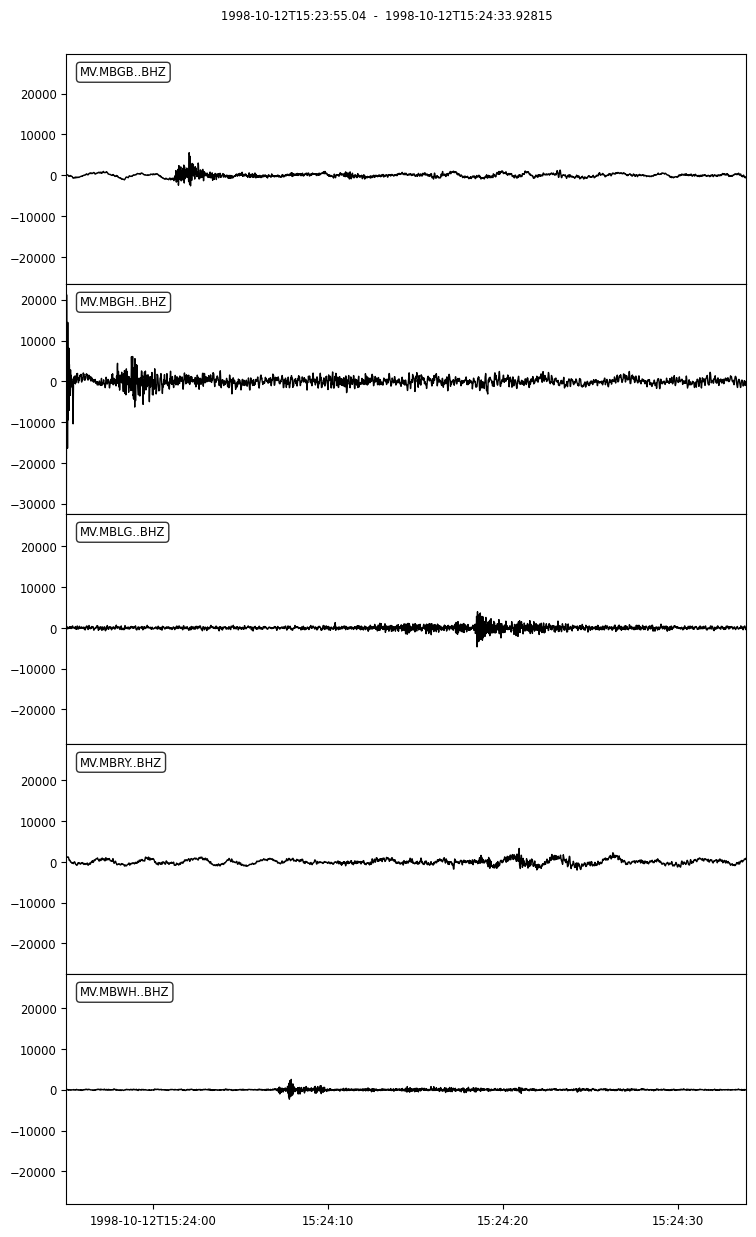

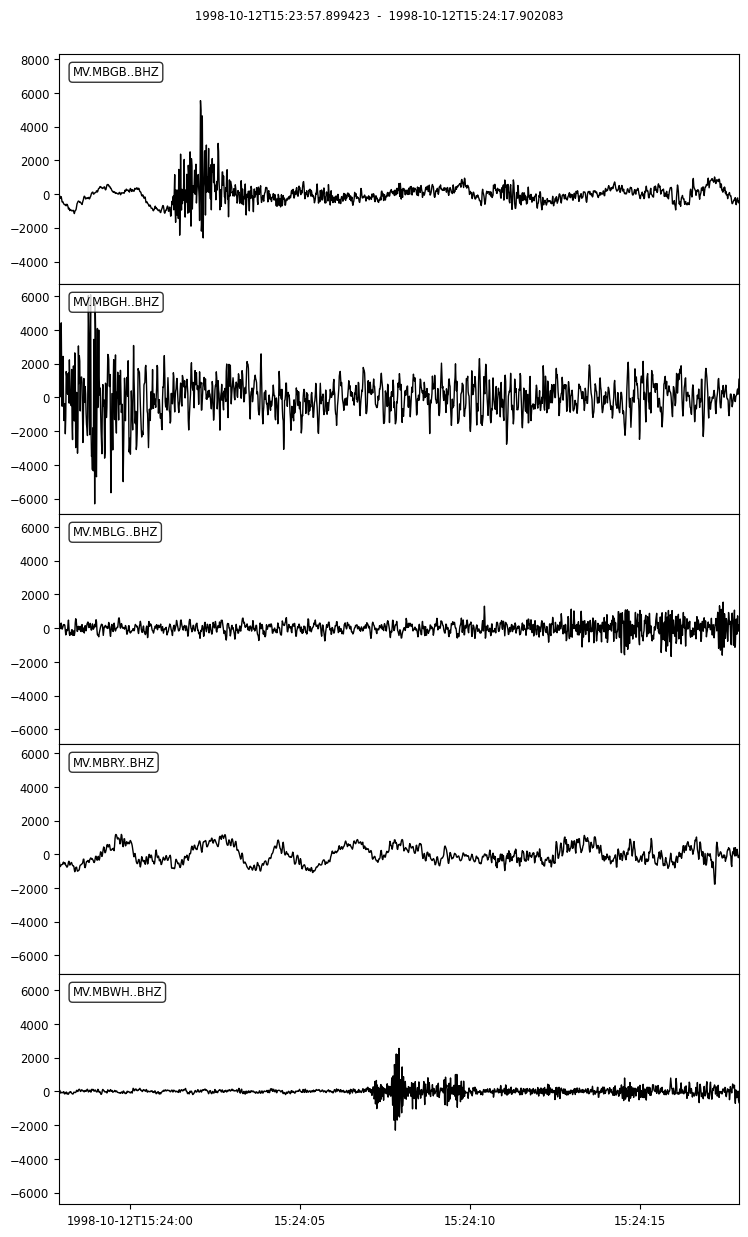

             id  peaktime  kurtosis  medianF   peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBRY..BHZ    25.894     0.373    7.875   0.000     0.0     1.1      -0.465     0.373  1.397e+07
1  MV.MBLG..BHZ    23.487    12.974   14.587  19.238     1.5    21.5       0.055    12.974  8.711e+06
2  MV.MBGH..BHZ     0.000   127.110   10.985   0.000     0.0     7.1      -0.508   127.110  6.965e+07
3  MV.MBWH..BHZ    12.861    32.821   16.223   1.469     0.0    30.5      -0.163    32.821  1.617e+06
4  MV.MBGB..BHZ     7.022    15.355   10.507   0.000     0.0     1.1      -0.307    15.355  9.084e+06
The event is classified as r, but here are our guesses:
subclass: D, points = 0.000000, probability = 0.000
subclass: R, points = 0.000000, probability = 0.000
subclass: r, points = 0.229708, probability = 0.037
subclass: e, points = 0.016884, probability = 0.003
subclass: l, points = 0.674092, probability = 0.108
subclass: h, points = 0.564143, probability = 0.090
subclass: t, points 

	 ? u


Loading /Users/thompsong/DATA/MVO/./PICKLE/MVOE_/1997/04/9704-13-1201-54S.MVO_18_1.pickle


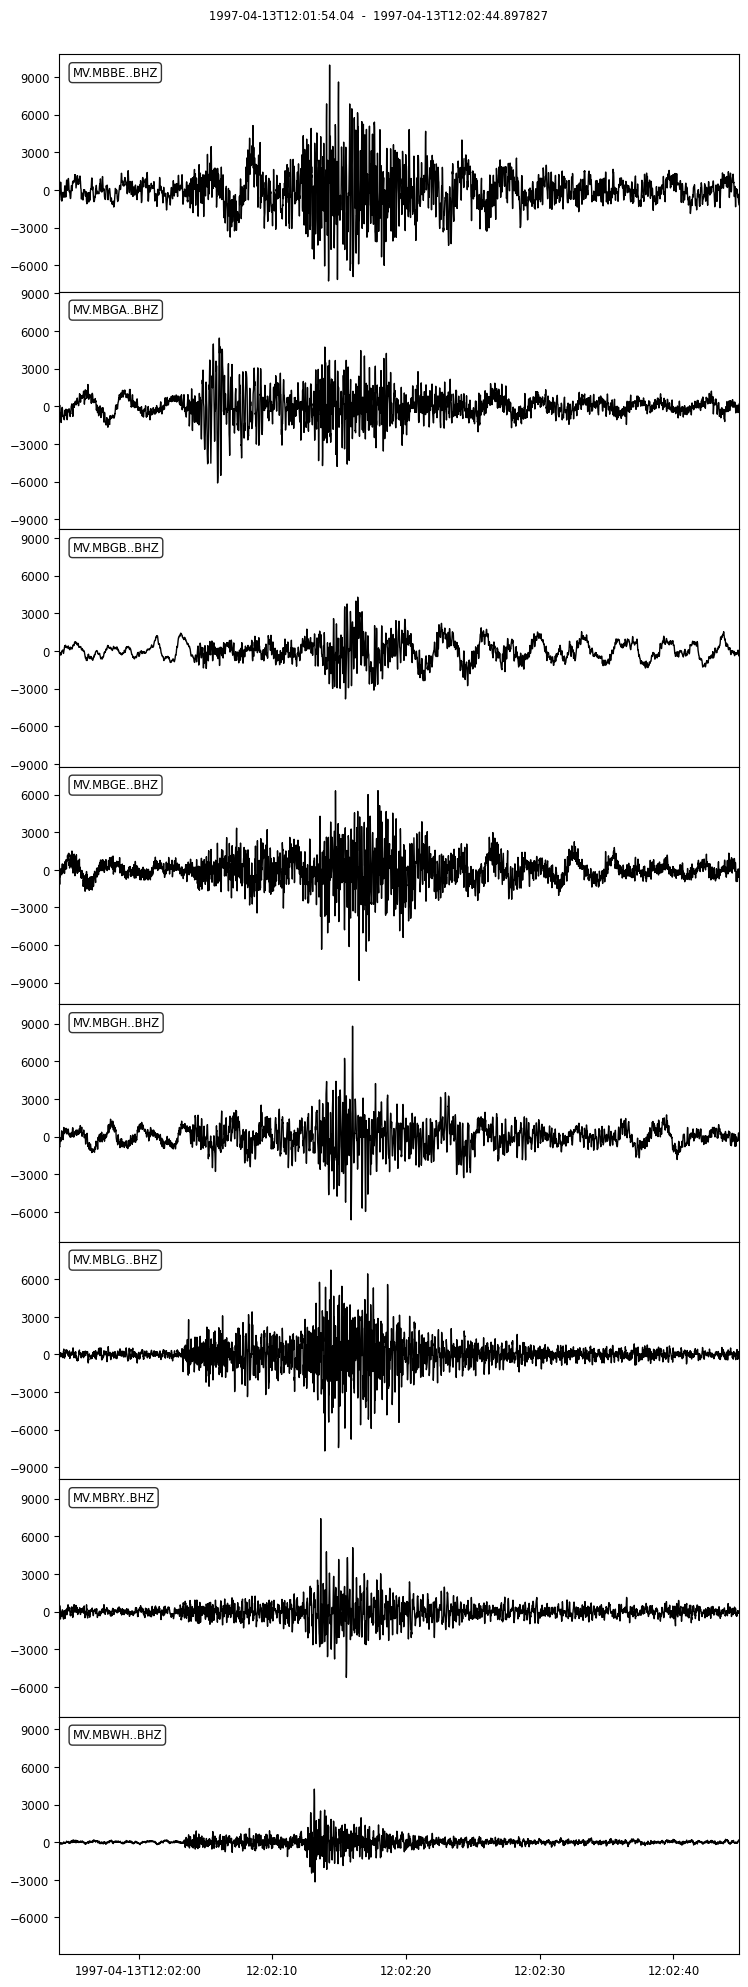

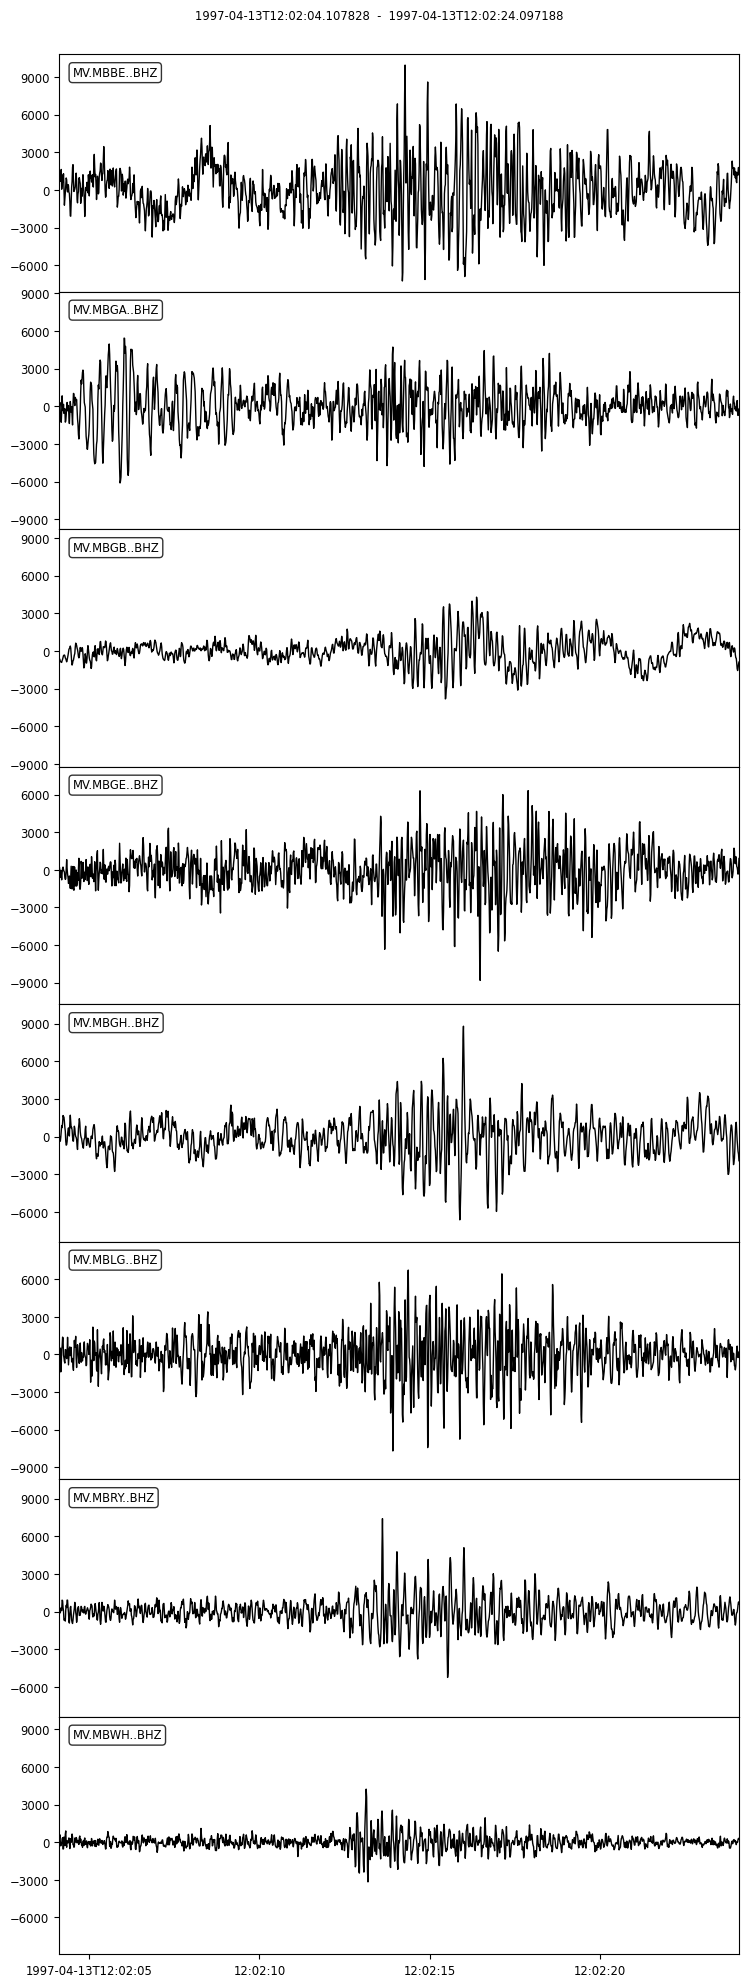

             id  peaktime  kurtosis  medianF  peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBGA..BHZ    11.863     4.300    9.479  0.000     0.0     5.3      -0.671     4.300  5.858e+07
1  MV.MBLG..BHZ    19.883     8.637   12.021  4.406     3.0    10.8      -0.282     8.637  5.586e+07
2  MV.MBRY..BHZ    19.577    12.126    9.867  3.965     2.6     5.9      -0.475    12.126  2.472e+07
3  MV.MBGE..BHZ    22.450     5.494   10.446  0.000     0.0     1.1       0.060     5.494  6.723e+07
4  MV.MBGH..BHZ    21.958     6.157    7.661  0.000     0.0     5.0      -0.937     6.157  5.718e+07
5  MV.MBWH..BHZ    19.098    19.559   11.548  7.930     0.7    11.5      -0.035    19.559  6.640e+06
6  MV.MBBE..BHZ    20.242     4.014    9.245  0.000     0.0     1.3      -0.328     4.014  1.089e+08
7  MV.MBGB..BHZ    22.343     1.999    6.359  0.000     0.0     1.1      -0.551     1.999  3.466e+07
The event is classified as r, but here are our guesses:
subclass: D, points = 0.000000, pro

	 ? R, 50


Processing  e
Processing 2 events of type e
Loading /Users/thompsong/DATA/MVO/./PICKLE/MVOE_/2001/08/2001-08-08-1344-24S.MVO___018.pickle


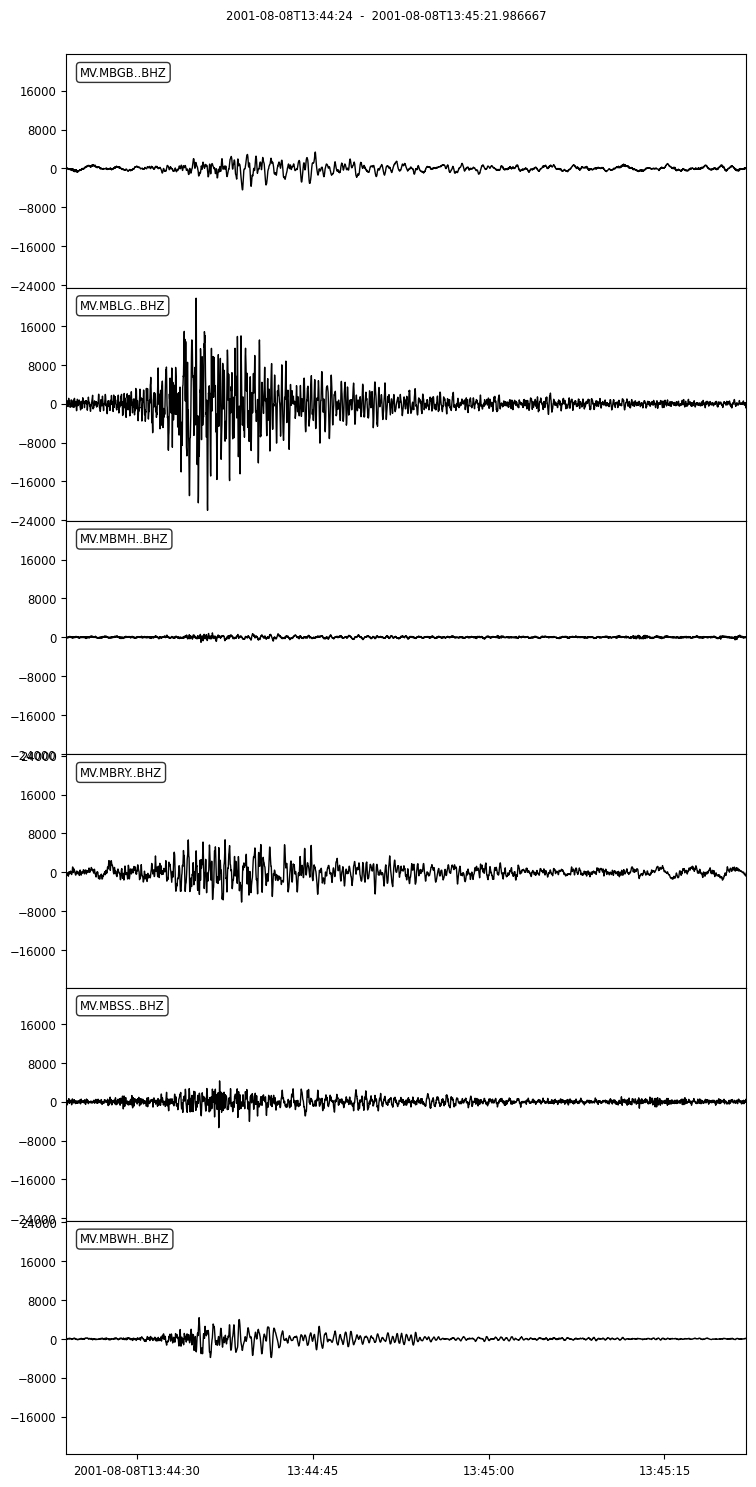

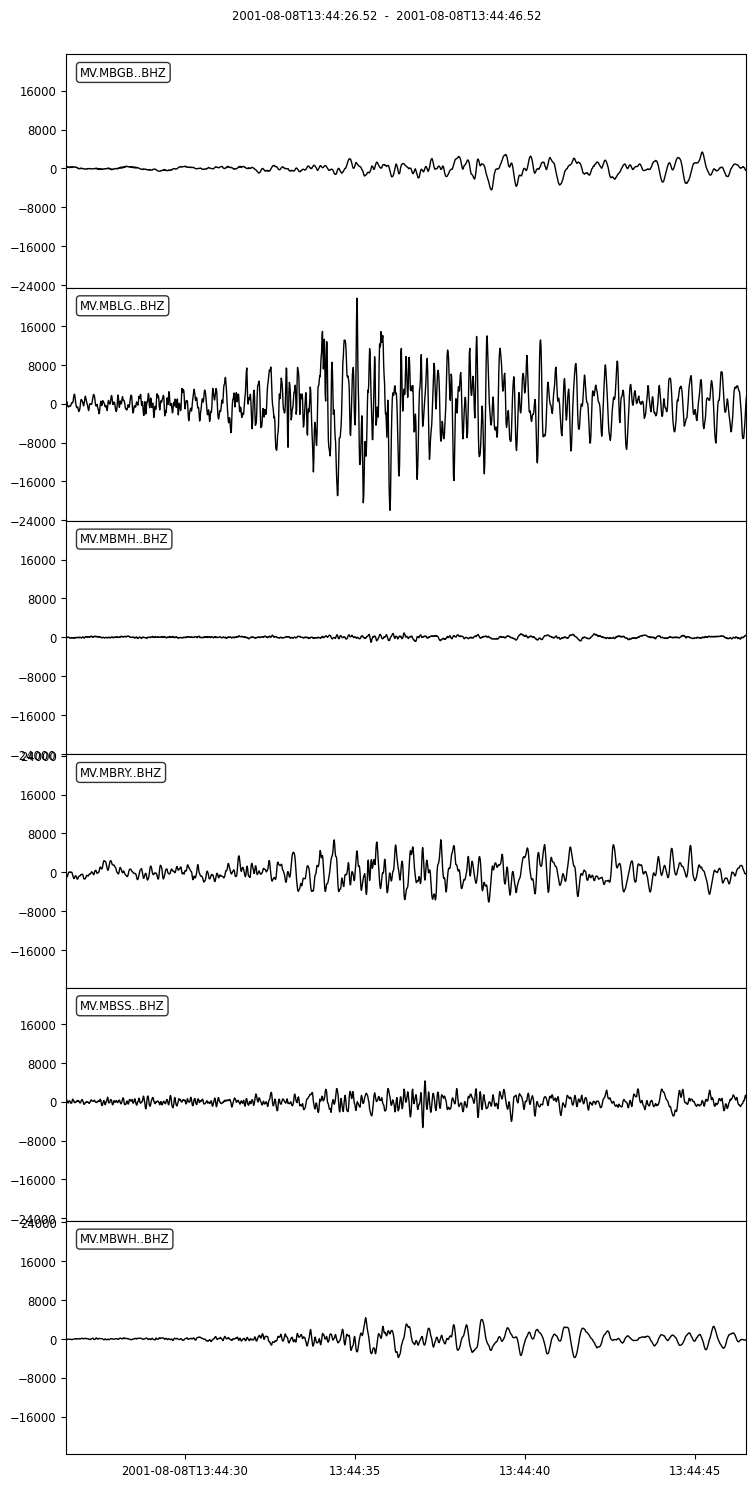

             id  peaktime  kurtosis  medianF  peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBGB..BHZ    15.027     5.689    4.779  1.025     0.0     2.1      -2.843     5.689  2.898e+07
1  MV.MBLG..BHZ    12.040     9.435    6.815  2.930     1.7     4.3      -1.311     9.435  5.379e+08
2  MV.MBMH..BHZ    11.480     3.257   10.344  1.318     0.0     2.6      -0.808     3.257  1.579e+06
3  MV.MBRY..BHZ    13.533     3.501    4.928  2.051     0.0     3.7      -1.774     3.501  1.112e+08
4  MV.MBSS..BHZ    13.000     4.720    8.022  2.344     1.1     3.4      -0.377     4.720  2.887e+07
5  MV.MBWH..BHZ    11.320     7.523    4.882  1.904     0.9     3.1      -2.511     7.523  2.997e+07
The event is classified as e, but here are our guesses:
subclass: D, points = 0.000000, probability = 0.000
subclass: R, points = 0.000000, probability = 0.000
subclass: r, points = 5.411800, probability = 0.175
subclass: e, points = 6.322958, probability = 0.205
subclass: l, points = 2.74833

	 ? r, 50, h, 10, 1


Loading /Users/thompsong/DATA/MVO/./PICKLE/MVOE_/2001/08/2001-08-07-0125-26S.MVO___018.pickle


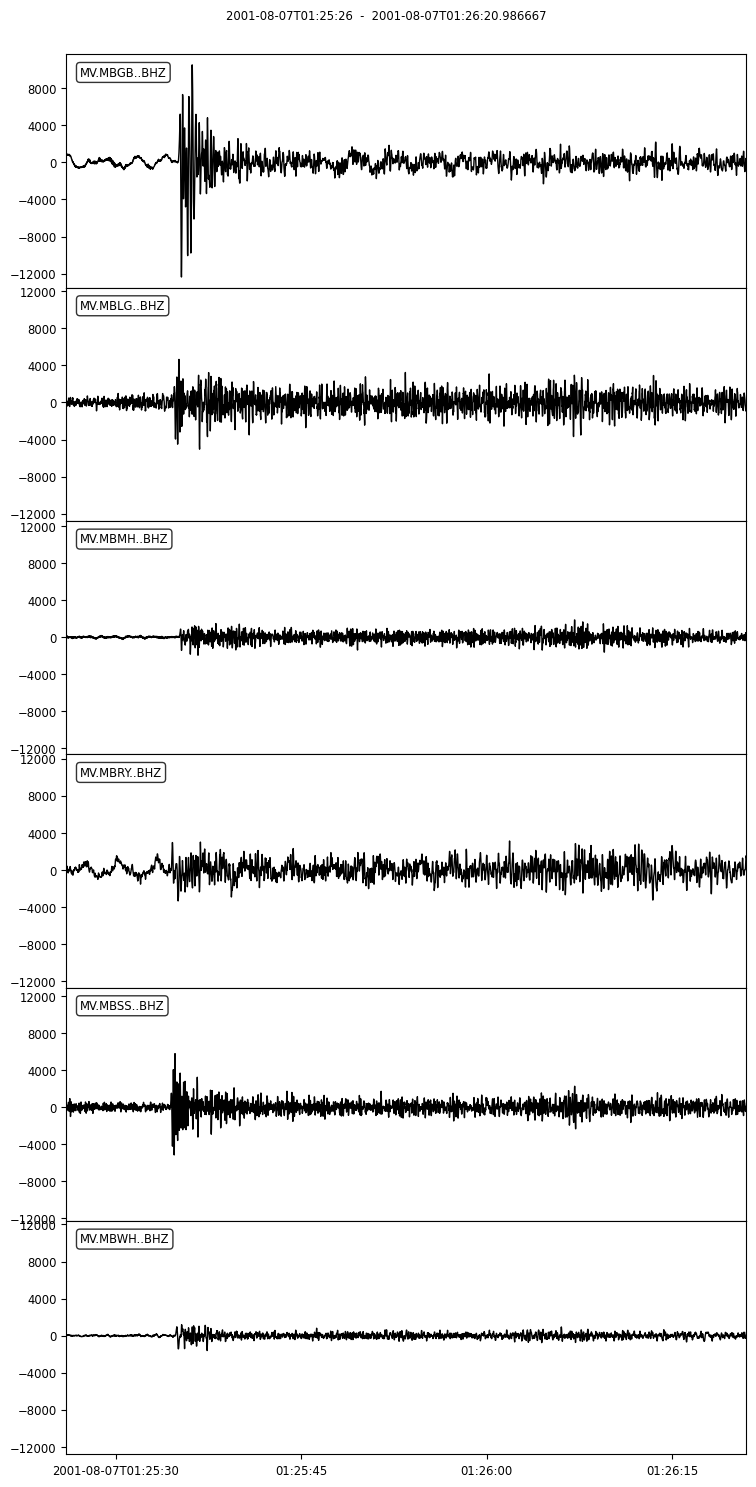

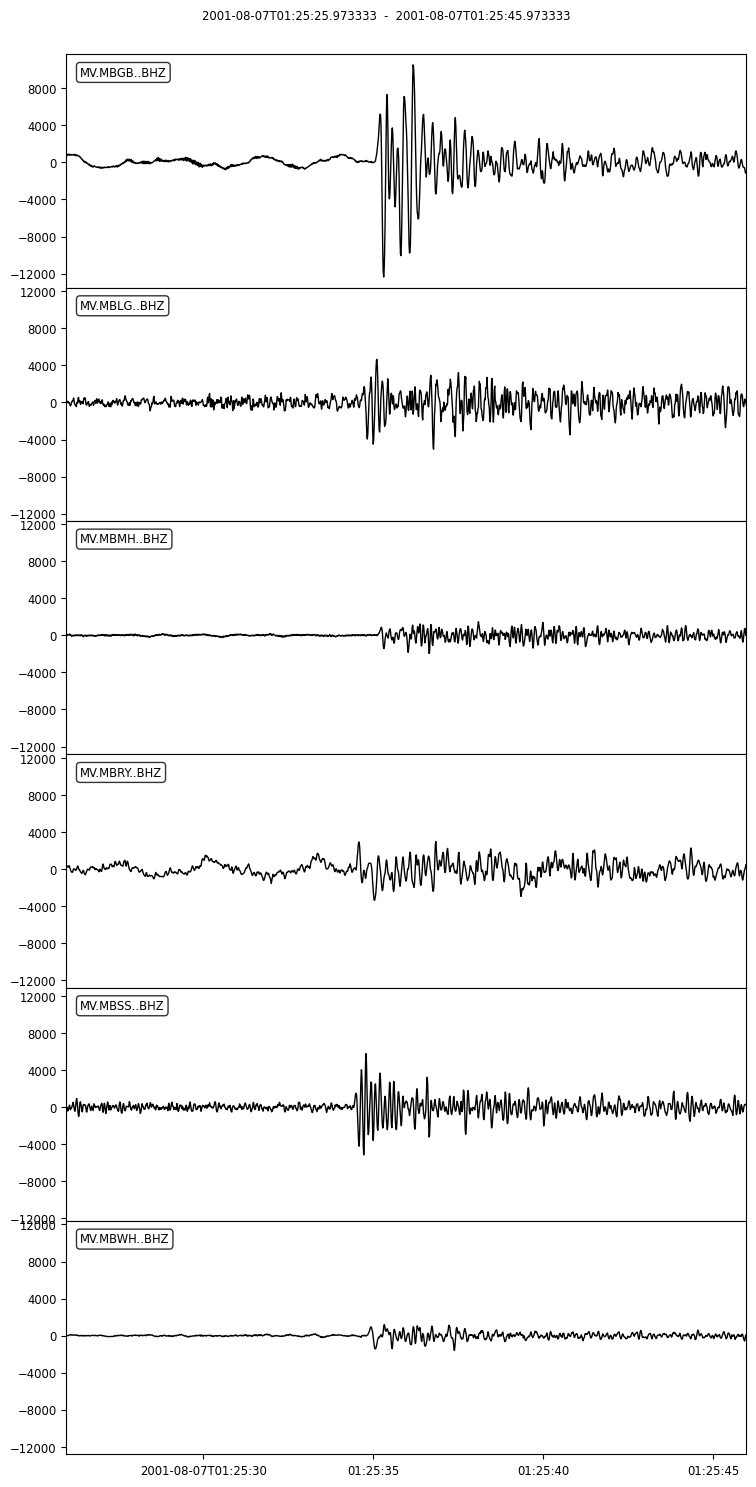

             id  peaktime  kurtosis  medianF  peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBGB..BHZ     9.307    31.870    6.346  0.293     0.0     6.7      -1.328    31.870  6.891e+07
1  MV.MBLG..BHZ    10.773     1.646   10.110  5.127     2.9     7.6      -0.606     1.646  4.658e+07
2  MV.MBMH..BHZ    10.640     1.043    9.637  7.764     5.3    10.0       0.383     1.043  9.805e+06
3  MV.MBRY..BHZ     9.040     0.399    6.369  0.146     0.0     5.4      -0.973     0.399  4.258e+07
4  MV.MBSS..BHZ     8.787     7.996    9.129  7.031     5.0     8.5       0.040     7.996  2.377e+07
5  MV.MBWH..BHZ    11.387     3.291    8.951  2.344     1.1     8.6      -0.476     3.291  3.552e+06
The event is classified as e, but here are our guesses:
subclass: D, points = 0.000000, probability = 0.000
subclass: R, points = 0.000000, probability = 0.000
subclass: r, points = 1.631338, probability = 0.301
subclass: e, points = 1.000376, probability = 0.185
subclass: l, points = 1.65902

	 ? 


Processing  l
Processing 2 events of type l
Loading /Users/thompsong/DATA/MVO/./PICKLE/MVOE_/2001/08/2001-08-06-0709-47S.MVO___018.pickle


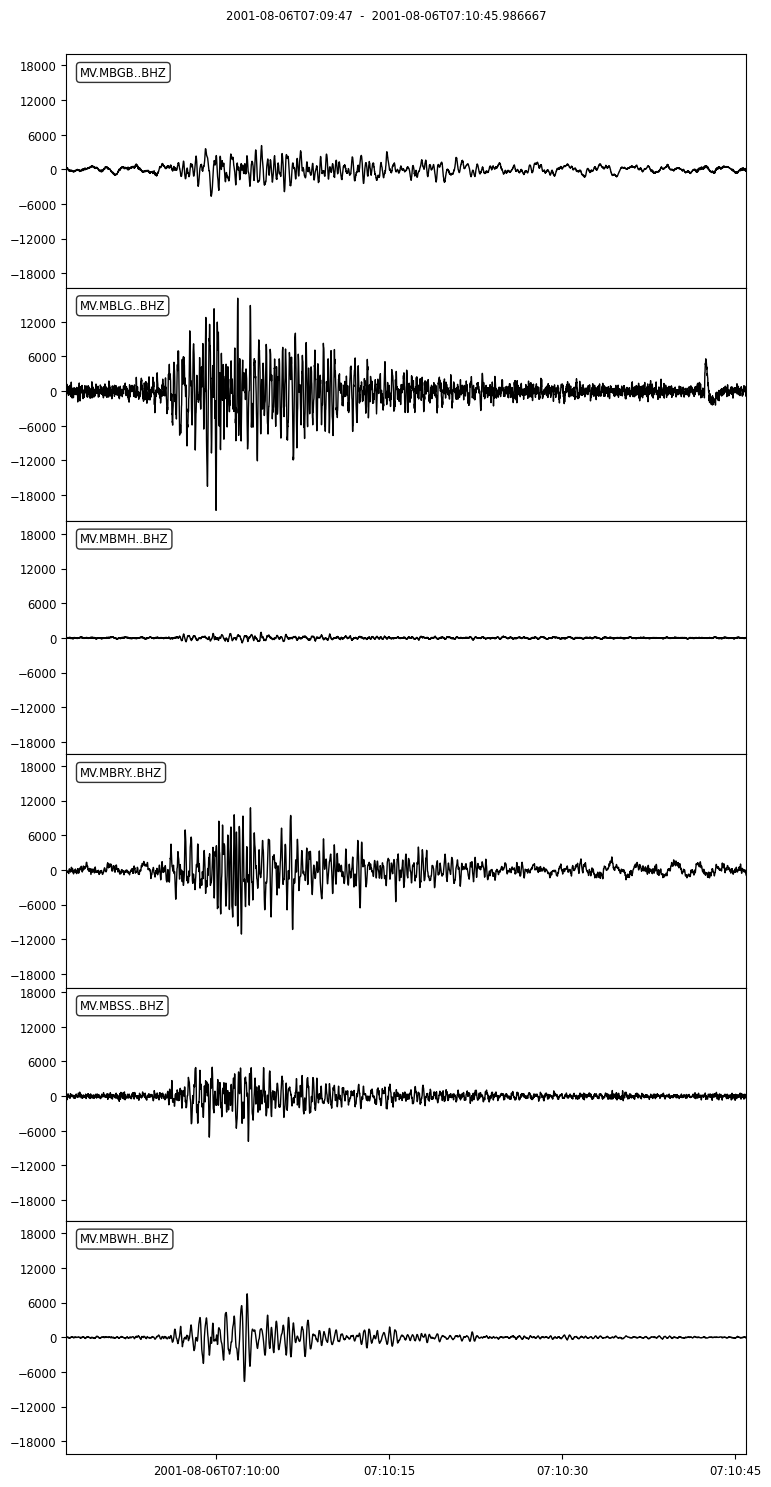

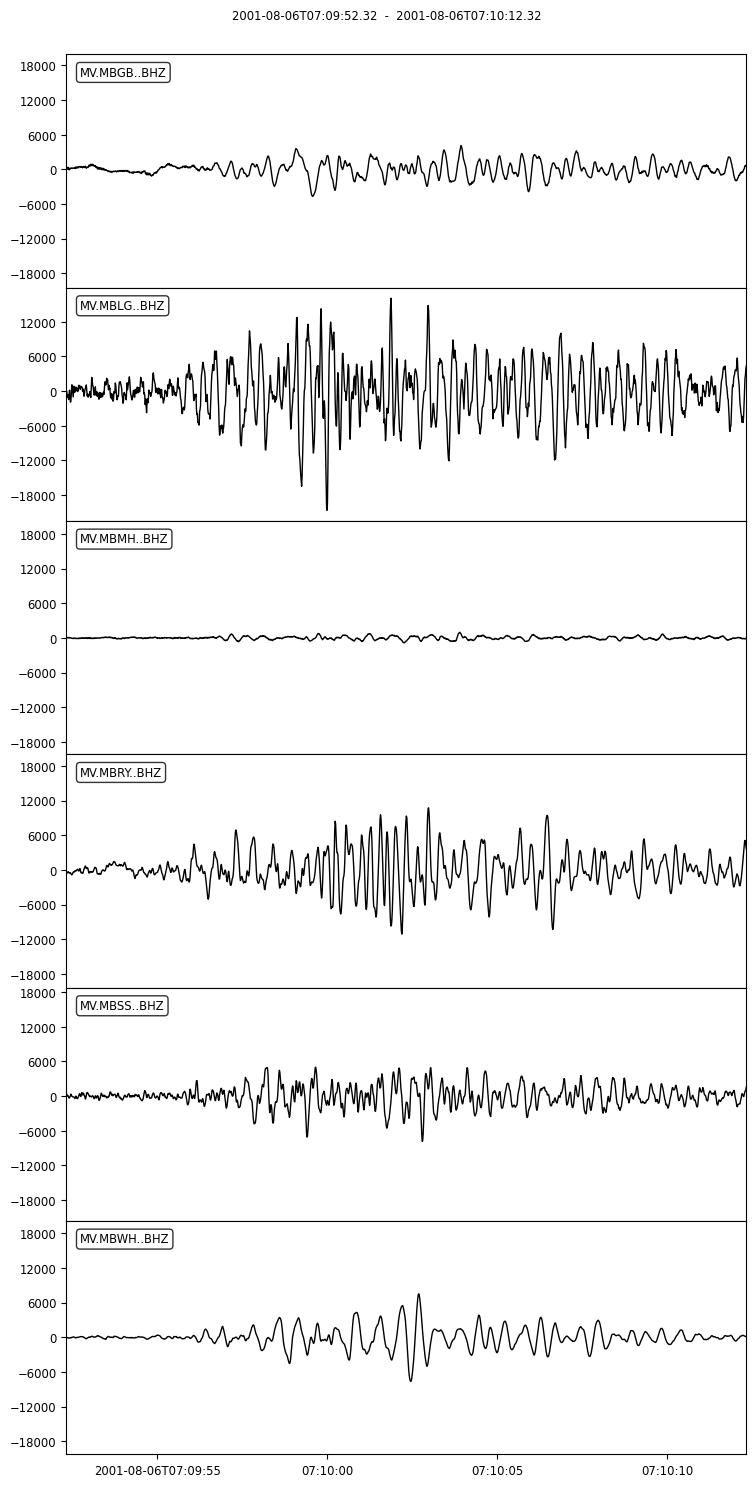

             id  peaktime  kurtosis  medianF  peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBGB..BHZ    12.573     3.004    4.677  1.025     0.0     2.9      -3.702     3.004  4.847e+07
1  MV.MBLG..BHZ    12.987     7.291    8.831  2.783     1.7     4.1      -1.822     7.291  4.455e+08
2  MV.MBMH..BHZ    16.893     4.325    8.340  1.465     0.4     2.9      -2.143     4.325  1.572e+06
3  MV.MBRY..BHZ    15.187     6.098    4.704  2.490     0.8     4.1      -2.339     6.098  2.244e+08
4  MV.MBSS..BHZ    15.787     7.664    7.024  2.197     1.2     3.3      -1.316     7.664  6.910e+07
5  MV.MBWH..BHZ    15.453    13.284    3.813  1.904     1.0     2.9      -3.645    13.284  6.040e+07
The event is classified as l, but here are our guesses:
subclass: D, points = 0.000000, probability = 0.000
subclass: R, points = 0.000000, probability = 0.000
subclass: r, points = 3.604126, probability = 0.164
subclass: e, points = 4.248702, probability = 0.194
subclass: l, points = 4.04553

	 ? r, 50, l, 50


Loading /Users/thompsong/DATA/MVO/./PICKLE/MVOE_/2001/09/2001-09-18-1612-14S.MVO___014.pickle


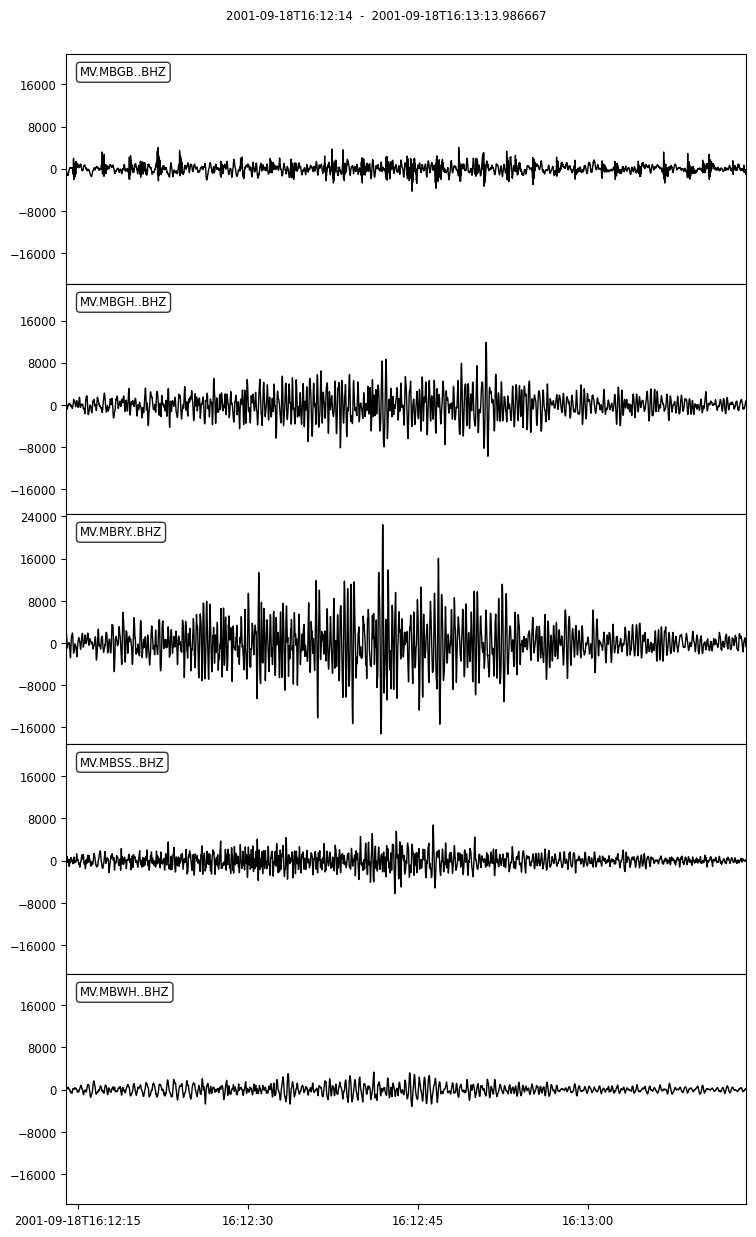

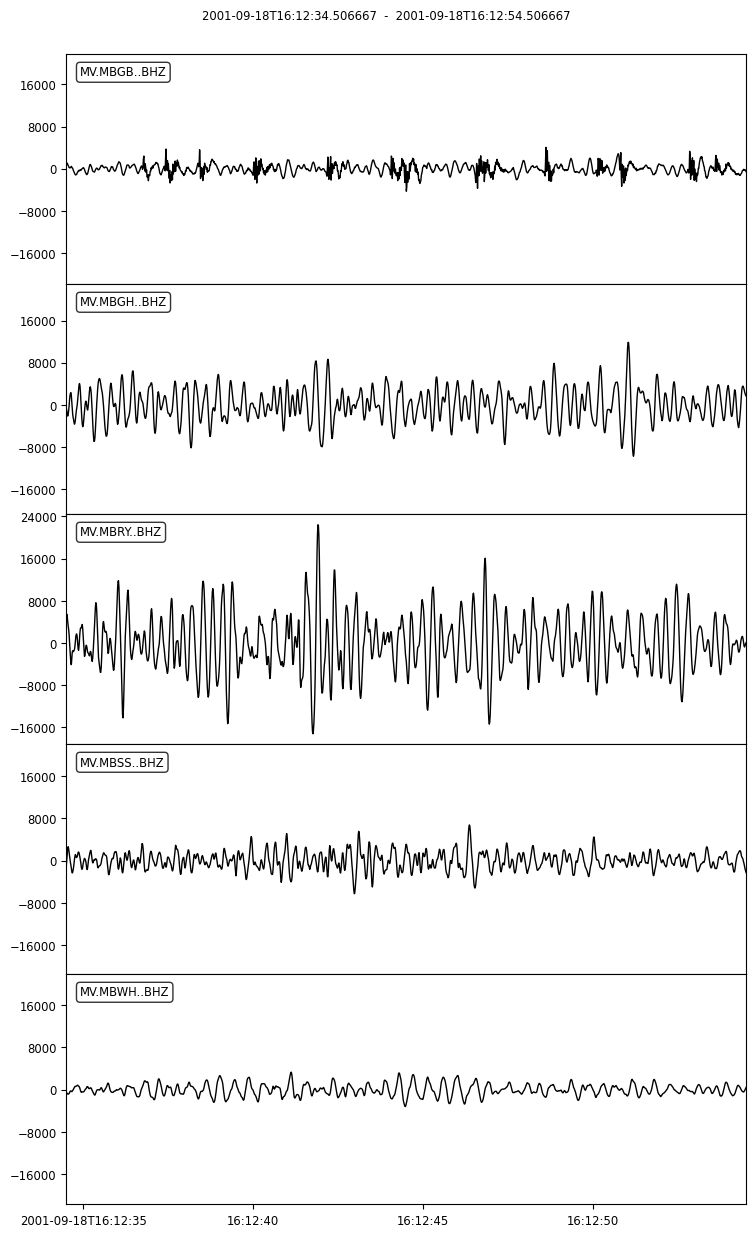

             id  peaktime  kurtosis  medianF  peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBGB..BHZ    30.507     2.023   12.162  2.637     0.0     4.2      -2.375     2.023  3.582e+07
1  MV.MBGH..BHZ    37.040     2.022    4.544  2.930     1.9     4.2      -3.011     2.022  2.813e+08
2  MV.MBRY..BHZ    27.907     2.874    4.656  3.223     2.2     4.3      -2.699     2.874  8.143e+08
3  MV.MBSS..BHZ    32.360     2.274    6.039  2.783     1.7     4.5      -1.423     2.274  8.811e+07
4  MV.MBWH..BHZ    27.120     1.288    4.268  2.197     1.3     3.3      -2.831     1.288  3.951e+07
The event is classified as l, but here are our guesses:
subclass: D, points = 0.000000, probability = 0.000
subclass: R, points = 0.000000, probability = 0.000
subclass: r, points = 3.509989, probability = 0.278
subclass: e, points = 3.229603, probability = 0.256
subclass: l, points = 1.674758, probability = 0.133
subclass: h, points = 1.134072, probability = 0.090
subclass: t, points = 1.94

	 ? s


Processing  h
Processing 2 events of type h
Loading /Users/thompsong/DATA/MVO/./PICKLE/MVOE_/1997/04/9704-04-0803-20S.MVO_18_1.pickle


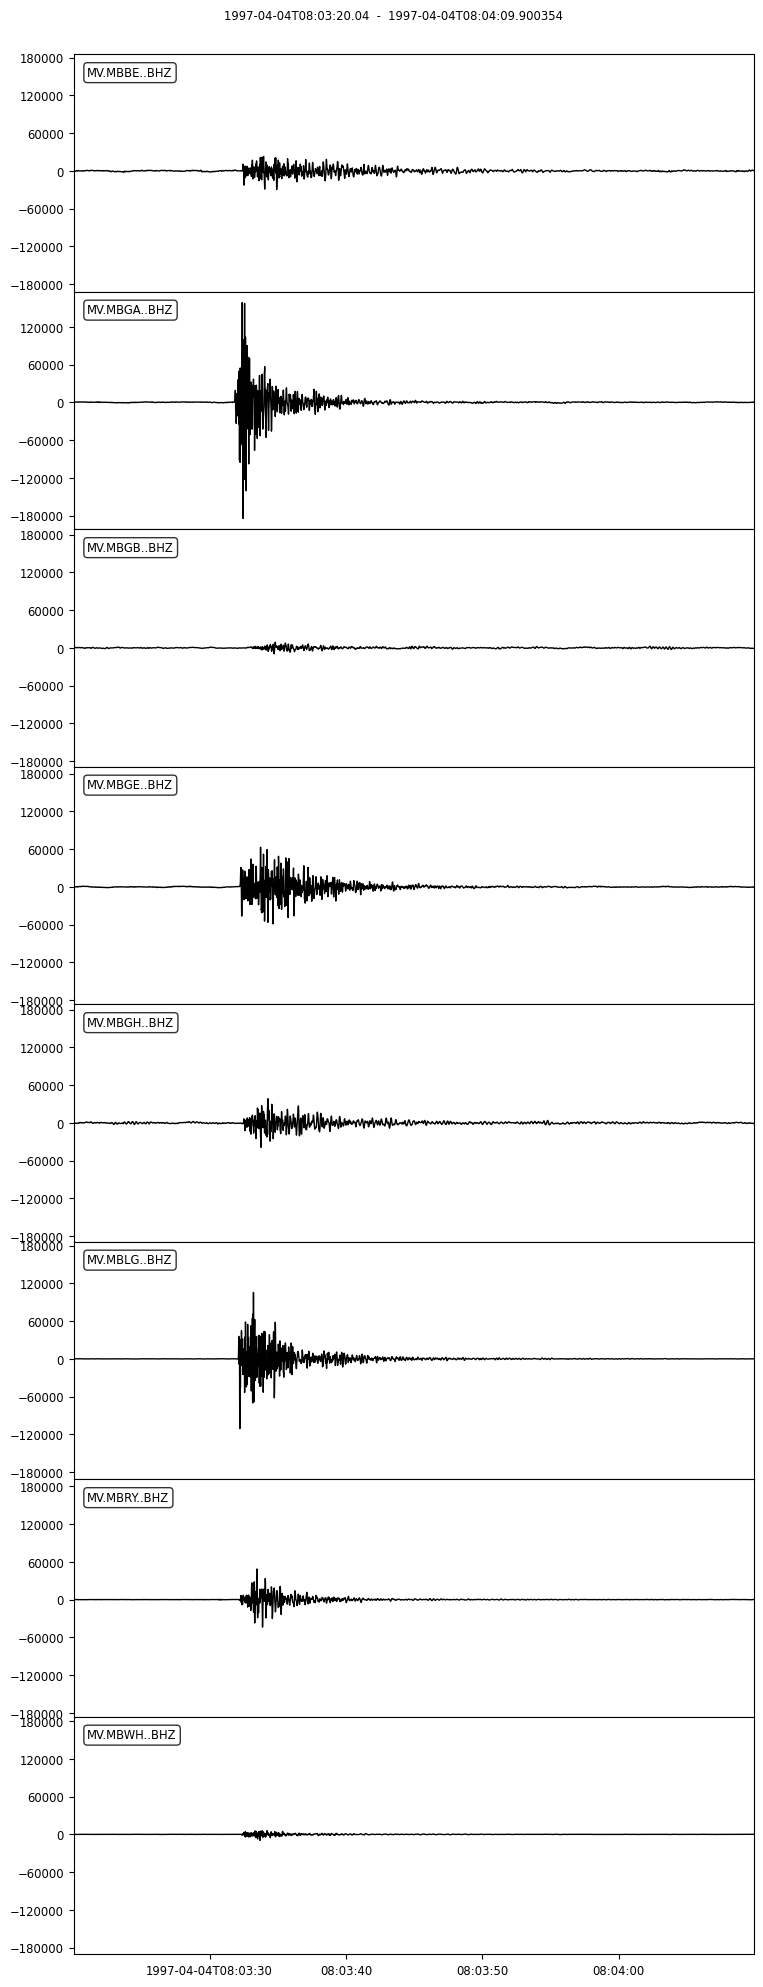

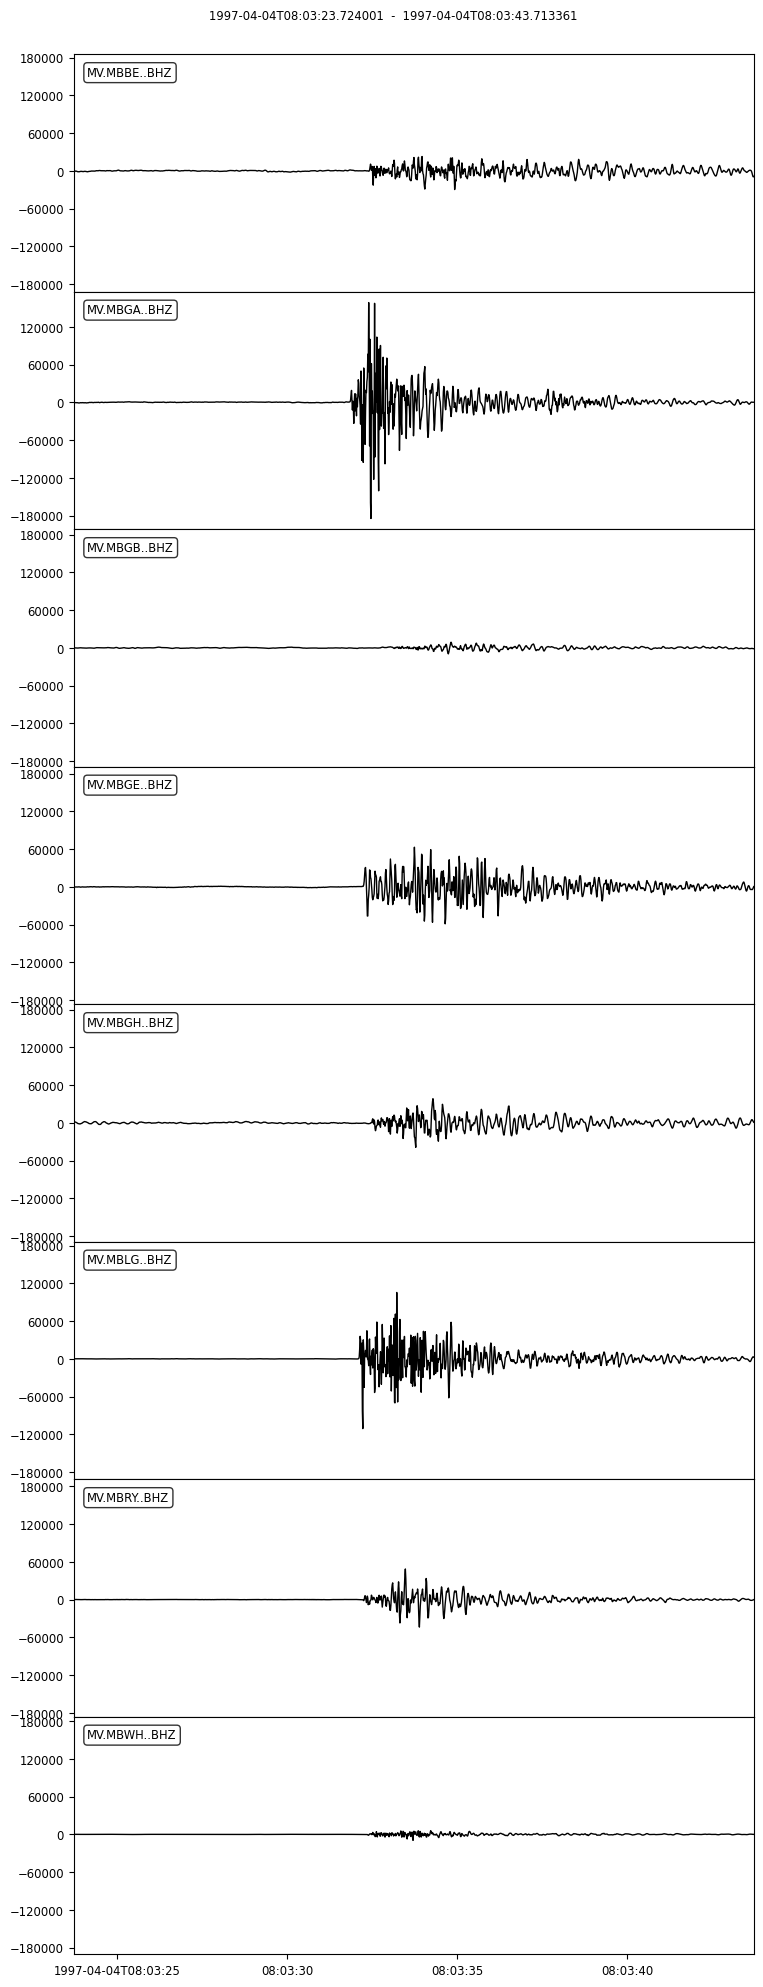

             id  peaktime  kurtosis  medianF  peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBGA..BHZ    12.422    92.793   13.305  4.846     3.3     6.4      -0.488    92.793  5.800e+09
1  MV.MBLG..BHZ    12.182    52.218   13.845  4.553     3.1     9.8      -0.234    52.218  2.795e+09
2  MV.MBRY..BHZ    13.433    49.318    8.978  4.112     2.6     6.0      -0.671    49.318  6.115e+08
3  MV.MBGE..BHZ    13.699    21.025    9.960  5.727     3.8     9.3       0.026    21.025  2.461e+09
4  MV.MBGH..BHZ    13.739    18.240    7.528  3.378     2.2     5.9      -1.683    18.240  8.358e+08
5  MV.MBWH..BHZ    13.659    33.812   10.347  2.497     1.4     3.9      -1.059    33.812  2.362e+07
6  MV.MBBE..BHZ    14.882    12.427    8.436  3.525     2.0     5.8      -1.124    12.427  5.836e+08
7  MV.MBGB..BHZ    14.696     9.635    5.858  0.147     0.0     5.4      -1.781     9.635  6.738e+07
The event is classified as h, but here are our guesses:
subclass: D, points = 0.000000, pro

	 ? h, 50, l, 50


Loading /Users/thompsong/DATA/MVO/./PICKLE/MVOE_/1998/04/9804-02-0305-31S.MVO_18_1.pickle


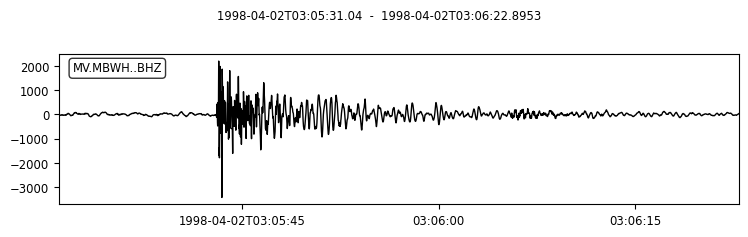

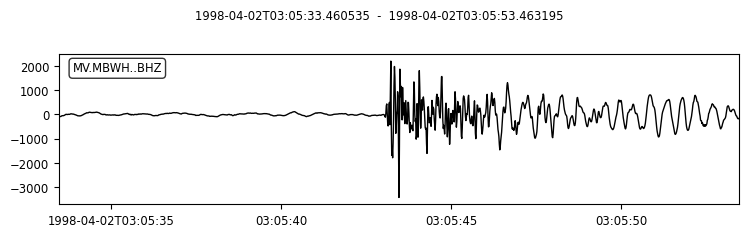

             id  peaktime  kurtosis  medianF  peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBWH..BHZ    12.422    18.007    6.889  2.056     1.0     3.0      -1.417    18.007  3.431e+06
The event is classified as h, but here are our guesses:
subclass: D, points = 0.000000, probability = 0.000
subclass: R, points = 0.000000, probability = 0.000
subclass: r, points = 5.991370, probability = 0.243
subclass: e, points = 4.000937, probability = 0.162
subclass: l, points = 1.164481, probability = 0.047
subclass: h, points = 4.253711, probability = 0.172
subclass: t, points = 3.504101, probability = 0.142
subclass: m, points = 0.000000, probability = 0.000
subclass: n, points = 5.766199, probability = 0.234
subclass: u, points = 0.000000, probability = 0.000
Please reclassify the event.
Valid subclasses are:  ['D', 'R', 'r', 'e', 'l', 'h', 't', 'n', 'u']
To enter percentage probabilities, e.g. 75% l, 25%h, enter l, 75, h, 25
Optionally add a weight [0-9] too with a trailing in

	 ? h


Processing  t
Processing 2 events of type t
Loading /Users/thompsong/DATA/MVO/./PICKLE/MVOE_/1998/04/9804-13-1230-07S.MVO_18_1.pickle


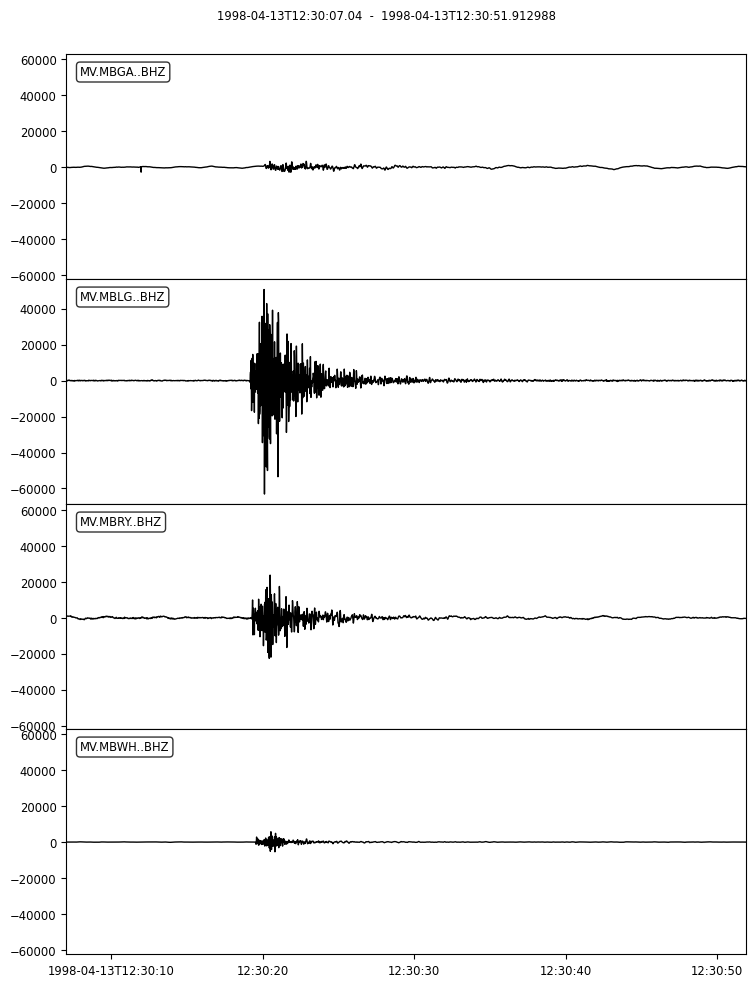

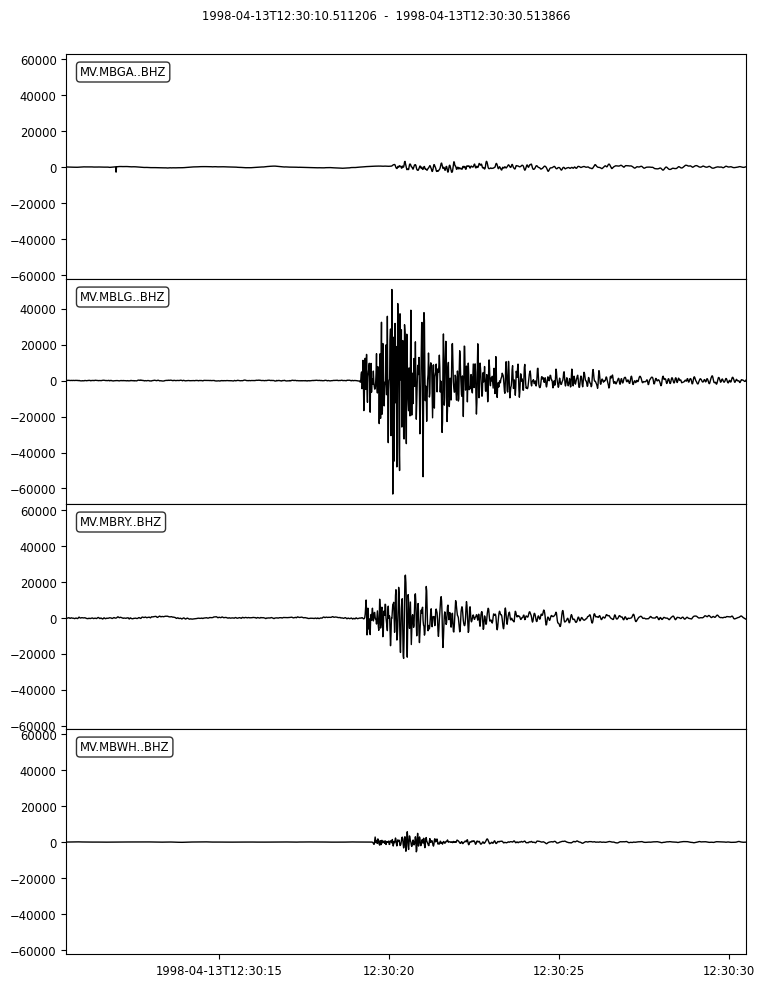

             id  peaktime  kurtosis  medianF   peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBGA..BHZ    15.827     4.102    5.504   0.000     0.0     1.1      -1.008     4.102  1.292e+07
1  MV.MBLG..BHZ    13.074    47.135   14.931  15.420     8.3    16.8       0.533    47.135  1.008e+09
2  MV.MBRY..BHZ    13.446    39.277    9.284   0.000     0.0    10.7       0.178    39.277  1.966e+08
3  MV.MBWH..BHZ    13.499    63.698   10.365   2.203     0.9     3.7      -0.527    63.698  7.099e+06
The event is classified as t, but here are our guesses:
subclass: D, points = 0.000000, probability = 0.000
subclass: R, points = 0.000000, probability = 0.000
subclass: r, points = 1.938199, probability = 0.113
subclass: e, points = 1.812051, probability = 0.105
subclass: l, points = 1.967520, probability = 0.115
subclass: h, points = 1.948499, probability = 0.113
subclass: t, points = 7.121304, probability = 0.415
subclass: m, points = 0.000000, probability = 0.000
subclass: n, point

	 ? t, 100, 9


Loading /Users/thompsong/DATA/MVO/./PICKLE/MVOE_/1997/04/9704-10-1935-37S.MVO_18_1.pickle


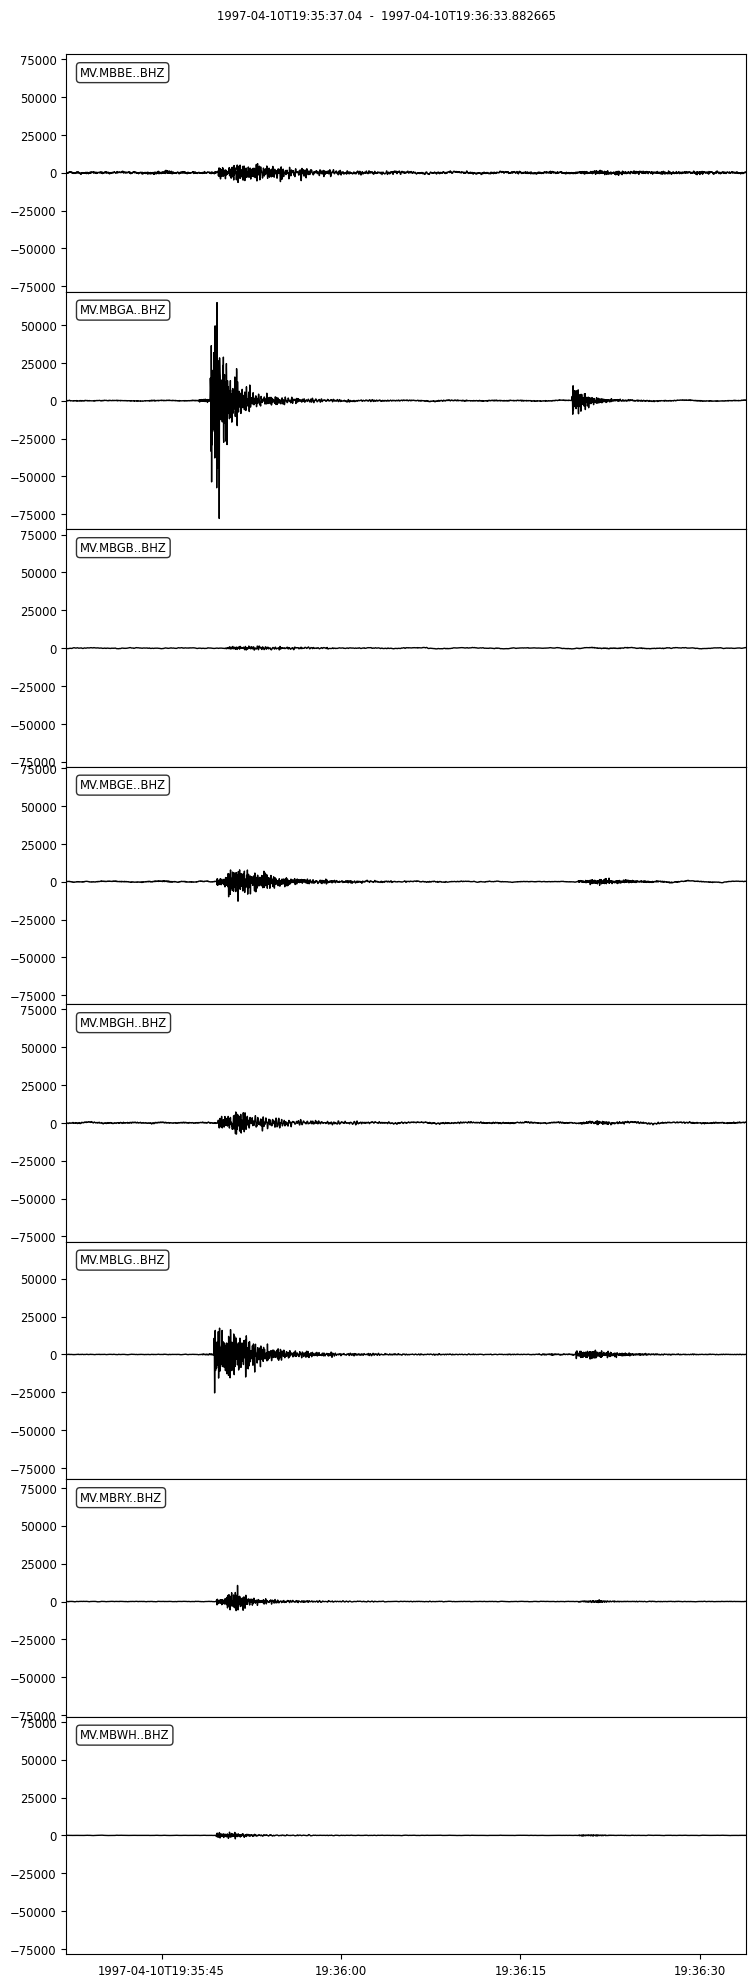

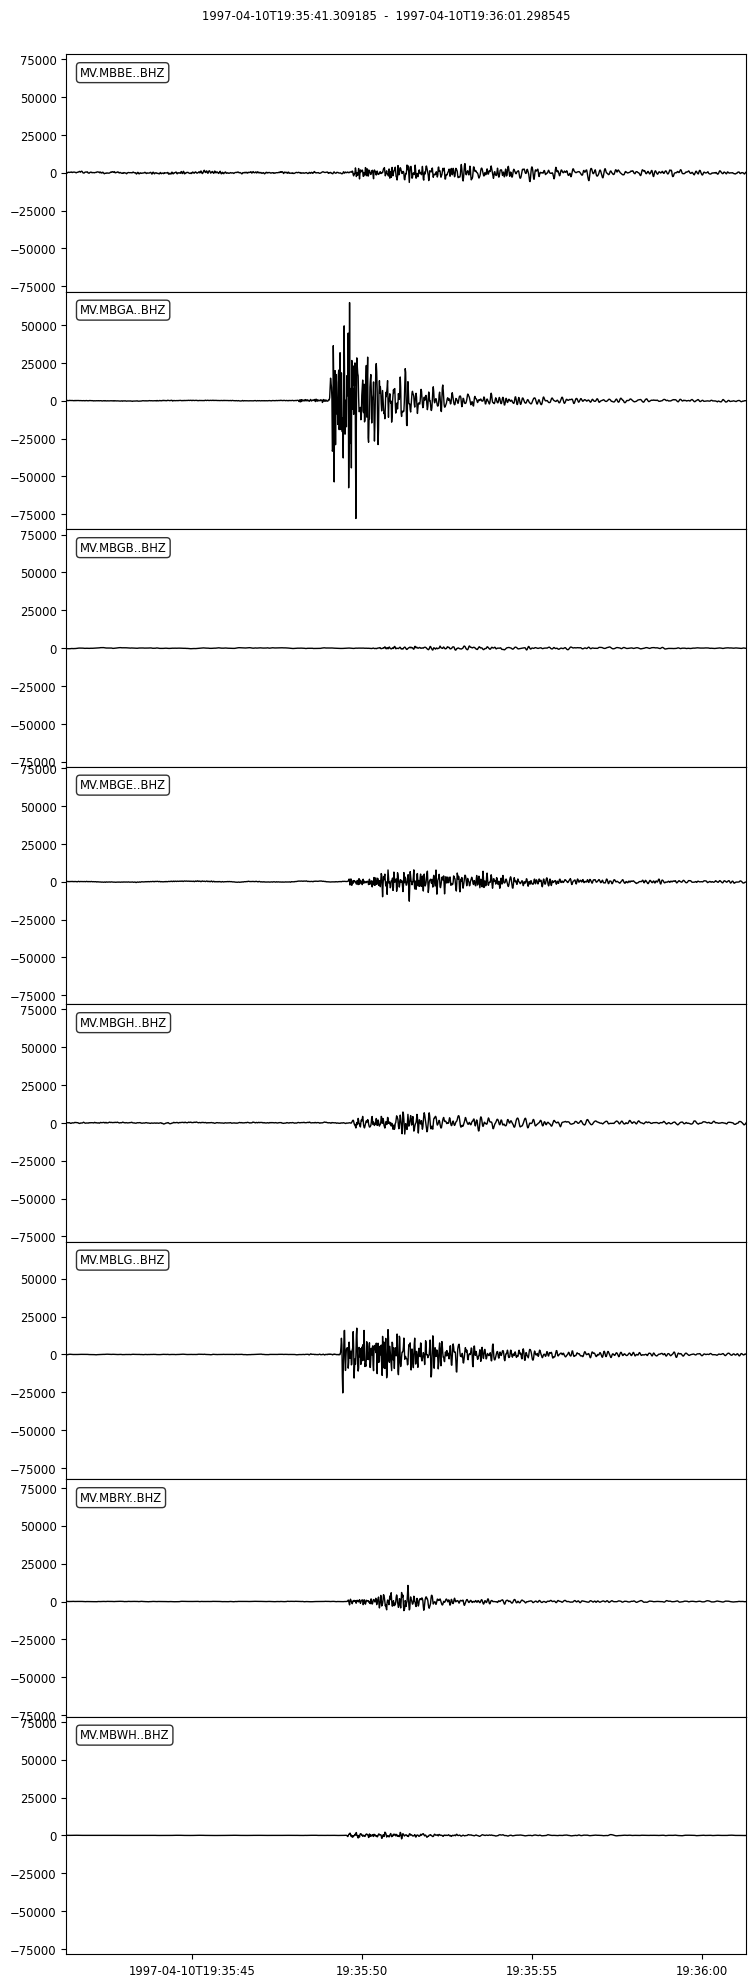

             id  peaktime  kurtosis  medianF  peakF  bw_min  bw_max  band_ratio  kurtosis     energy
0  MV.MBGA..BHZ    12.781   122.500   15.006  7.636     5.3    13.4       0.776   122.500  8.005e+08
1  MV.MBLG..BHZ    12.395    38.542   13.319  8.518     4.6    15.6       0.581    38.542  1.812e+08
2  MV.MBRY..BHZ    14.310    65.352   10.440  5.140     3.3    12.1      -0.381    65.352  1.852e+07
3  MV.MBGE..BHZ    14.350    31.816   12.131  0.000     0.0    11.1       0.722    31.816  4.983e+07
4  MV.MBGH..BHZ    14.217    19.343    8.678  4.259     0.0     6.9      -0.655    19.343  3.789e+07
5  MV.MBWH..BHZ    14.124    44.651   10.280  1.909     0.5     6.5      -0.754    44.651  1.797e+06
6  MV.MBBE..BHZ    14.350    10.048   10.525  7.636     0.0    13.1      -0.105    10.048  4.313e+07
7  MV.MBGB..BHZ    16.119     2.902    6.034  0.000     0.0     1.2      -0.894     2.902  3.596e+06
The event is classified as t, but here are our guesses:
subclass: D, points = 0.000000, pro

	 ? t, 100, 7


Checked events
subclass
e    2
h    2
l    2
r    2
t    2
Name: path, dtype: int64
Unchecked events
subclass
e    2
h    2
l    2
n    4
r    2
t    2
Name: path, dtype: int64


Do you want to iterate again (y/n)? n


Selecting 1 events of type r from a total of 4
Selecting 1 events of type e from a total of 4
Selecting 1 events of type l from a total of 4
Selecting 1 events of type h from a total of 4
Selecting 1 events of type t from a total of 4
Selecting 1 events of type n from a total of 4


AttributeError: 'tuple' object has no attribute 'keys'

In [37]:
SEISAN_DATA = os.path.join( os.getenv('HOME'),'DATA','MVO')
DB = 'MVOE_'
subclass_mapping = read_volcano_def()
print(subclass_mapping.columns)
SUBCLASSES = subclass_mapping['subclass'].values.tolist() # append('g') as needed, it is not an allowed subclass
ETYPES = subclass_mapping['etype'].values.tolist()

outfile = 'catalog_all.csv'

if os.path.exists(outfile):
    dfall = pd.read_csv(outfile)
else:
    master_event_catalog = 'catalog_all_original.csv'
    dfall = build_master_event_catalog(SEISAN_DATA, DB, master_event_catalog, SUBCLASSES, ETYPES)

# how many events of each type do we want?
_count_by_subclass(dfall)
choice = input('How many events of each subclass do you want in training+test datasets?')
N = int(choice)

iterate_again = True
while iterate_again:

    # get/update the fingerprints of each event class
    fingerprints = get_fingerprints(dfall, SUBCLASSES, N=300, exclude_checked=False)    

    # for further classification select best unchecked events of each subclass based on quality_index
    best_events_dict, left_behind_dict  = _select_best_events(dfall, SUBCLASSES, N=N, exclude_checked=True)
    result_dict = {}
    result_dict['unchecked'] = merge_dataframes(left_behind_dict, )

    # manually QC the data
    result_dict['checked'] = qc_best_events(best_events_dict, SUBCLASSES, fingerprints)
    frames = []
    for key, value in result_dict.items():
        frames.append(value) 
    dfall = pd.concat(frames, sort=True)   
    dfall.to_csv(outfile)
    _count_by_subclass(dfall)
    
    choice = input('Do you want to iterate again (y/n)?')
    if choice[0]=='n':
        iterate_again=False

# write out a catalog of the best events to Alexis' format  
best_events_dict, left_behind_dict = _select_best_events(dfall, SUBCLASSES, N=N, exclude_checked=False)
to_AAA(best_events_dict, SUBCLASSES)